In [3]:
import os
import shutil
import pickle
import navis
import numpy as np
import pandas as pd
from PIL import Image,ImageOps,ImageDraw, ImageFont
import nrrd# Some sample numpy
import plotly
import sys,os
sys.path.append('D:/code/neuron-vis/neuronvis/neuronVis')
import IONData as IONData
import SwcLoader as SwcLoader
sys.path.append('D://code//neuron-vis/core/code')

import GenerateterminalMatrix as GenerateterminalMatrix
import matplotlib.pyplot as plt
from collections import Counter
import HierarchicalClustering as HierarchicalClustering
from Plot import tSNE_Plot as tSNE_Plot
from Plot import Clustering_Plot as Clustering_Plot

from Plot import Soma_Dotplot as Soma_Dotplot
from sklearn import manifold, datasets
from scipy.cluster import hierarchy
import seaborn as sns
%matplotlib inline
iondata=IONData.IONData()
tree=SwcLoader.NeuronTree()
generatematrix=GenerateterminalMatrix.GenerateterminalMatrix()
clustering=HierarchicalClustering.HierarchicalClustering()
tsneplot=tSNE_Plot()
clusteringplot=Clustering_Plot()
 

# neuronlist=iondata.getNeuronListBySampleID('220241')+iondata.getNeuronListBySampleID('220240')
# neuronlist=[x['sampleid']+x['name'] for x in neuronlist]


In [4]:
f=open('D:\data\PF-fMOST\WT_fmost_analyzing/neuronlist.txt')
line = f.readline().strip() 
txt=[]
txt.append(line)
while line:  
   line = f.readline().strip()  
   txt.append(line)
f.close()  
print(txt)
neuronlist_WT=txt
neuronlist_WT=[x for x in neuronlist_WT if not x=='']

['210661077.swc', '220240001.swc', '220240004.swc', '220240006.swc', '220240031.swc', '220240033.swc', '220240035.swc', '220240036.swc', '220241010.swc', '220241011.swc', '220241012.swc', '220241014.swc', '220241015.swc', '220241018.swc', '220241019.swc', '220241020.swc', '220241021.swc', '220241022.swc', '220241023.swc', '220241024.swc', '220241025.swc', '220241026.swc', '220241027.swc', '220241028.swc', '220241029.swc', '220241031.swc', '220241032.swc', '220241033.swc', '220241034.swc', '220241035.swc', '220241036.swc', '220241043.swc', '220241046.swc', '220241053.swc', '220241054.swc', '220241055.swc', '220241056.swc', '220241058.swc', '220241059.swc', '220241060.swc', '220241061.swc', '220241062.swc', '']


In [5]:
# 143 个PF 神经元
f=open('D:\data\PF-fMOST/total/143_crelistneuronlist.txt')
line = f.readline().strip() 
txt=[]
txt.append(line)
while line:  
   line = f.readline().strip()  
   txt.append(line)
f.close()  
print(txt)
neuronlist_cre=txt
neuronlist_cre=[x for x in neuronlist_cre if not x=='']
neuronlist=neuronlist_WT+neuronlist_cre

['221624012.swc', '221624013.swc', '221624040.swc', '221624044.swc', '221624045.swc', '221624046.swc', '221624047.swc', '221624048.swc', '221624050.swc', '221624051.swc', '221624053.swc', '221624054.swc', '221624084.swc', '221624085.swc', '221624097.swc', '221624169.swc', '221624170.swc', '221624179.swc', '221624180.swc', '221612003.swc', '221612004.swc', '221612006.swc', '221612007.swc', '221612008.swc', '221612016.swc', '221612018.swc', '221612019.swc', '221612020.swc', '221612032.swc', '221612033.swc', '221612046.swc', '221612062.swc', '221612076.swc', '221612077.swc', '221612078.swc', '221612079.swc', '221612080.swc', '221625001.swc', '221625002.swc', '221625004.swc', '221625009.swc', '221625011.swc', '221625012.swc', '221625013.swc', '221625014.swc', '221643001.swc', '221643002.swc', '221643003.swc', '221643004.swc', '221643006.swc', '221643007.swc', '221643008.swc', '221643011.swc', '221643012.swc', '221643014.swc', '221643015.swc', '221643016.swc', '221643017.swc', '221643018.sw

In [ ]:
#获取各个神经元在不同脑区的terminal 数量
generatematrix=GenerateterminalMatrix.GenerateterminalMatrix()
generatematrix.generate_terminal_matrix(neuronlist,normalized=False,st_level=8,flip='left') # 神经元翻转到左侧统计，terminal 结果不进行标准化
neurondata_st8=generatematrix.terminaldata
# terminal_tem=generatematrix.terminal_tem
json_error=neurondata_st8.sum()[neurondata_st8.sum()==0]
print('error in json',json_error)


In [ ]:
#处理掉非基础脑区的信号，过低的噪音
neurondata_st8=neurondata_st8.loc[~(neurondata_st8==0).all(axis=1)]
region_st5_all=['Isocortex',
         'OLF',
         'HPF',
         'CTXsp',
         'STR',
         'PAL',
         'TH',
         'HY',
         'MB',
         'P',
         'MY',
         'CBX',
         'CBN']
 
primary_region=[x for x in neurondata_st8.index if not x[:x.index('.')] in region_st5_all]
neurondata_st8=neurondata_st8.loc[primary_region]
# neurondata_st8=neurondata_st8.drop(index='PF.left')
terminal_sum=neurondata_st8.sum()
propotion_terminal=neurondata_st8.div(terminal_sum)

region_tem=(neurondata_st8>0).sum(axis=1)
region_tem=region_tem[region_tem>10].index.to_list()#排除掉出现少于10次的脑区
neurondata_st8_screen=neurondata_st8.loc[region_tem]
neurondata_st8_screen=neurondata_st8_screen[neurondata_st8_screen>5]#排除掉terminal 数少的
propotion_terminal_log=neurondata_st8_screen.apply(np.log10)
propotion_terminal_log=propotion_terminal_log.fillna(0)






In [ ]:
neuronlist_df=pd.DataFrame(neuronlist,columns=['ID'])
neuronlist_calb1=iondata.getNeuronListBySampleID('221624')
neuronlist_calb2=iondata.getNeuronListBySampleID('221612')
neuronlist_pdyn1=iondata.getNeuronListBySampleID('221625')
neuronlist_pdyn2=iondata.getNeuronListBySampleID('221643')
neuronlist_Tnc=iondata.getNeuronListBySampleID('231628')
neuronlist_Tnc2=iondata.getNeuronListBySampleID('231629')
neuronlist_Tnc3=iondata.getNeuronListBySampleID('231630')
neuronlist=neuronlist_calb1+neuronlist_calb2+neuronlist_pdyn1+neuronlist_pdyn2+neuronlist_Tnc
neuronlist_p=neuronlist_pdyn1+neuronlist_pdyn2
neuronlist_c=neuronlist_calb1+neuronlist_calb2
neuronlist_t=neuronlist_Tnc+neuronlist_Tnc2+neuronlist_Tnc3

neuronlist_all=[]
neuronlist_calb=[]
neuronlist_pdyn=[]
neuronlist_Tnc=[]
for i in range(0,len(neuronlist)):
    neuronlist_all.append(str(neuronlist[i]['sampleid'] + neuronlist[i]['name']))
for i in range(0,len(neuronlist_c)):
    neuronlist_calb.append(str(neuronlist_c[i]['sampleid'] + neuronlist_c[i]['name']))
for i in range(0,len(neuronlist_p)):    
    neuronlist_pdyn.append(str(neuronlist_p[i]['sampleid'] + neuronlist_p[i]['name']))
for i in range(0,len(neuronlist_t)):    
    neuronlist_Tnc.append(str(neuronlist_t[i]['sampleid'] + neuronlist_t[i]['name']))

neuronlist_df['sourse']=''
for i in range(neuronlist_df.shape[0]):
     if neuronlist_df['ID'][i] in neuronlist_pdyn:
        neuronlist_df['sourse'][i]='Pdyn'        
     elif neuronlist_df['ID'][i] in neuronlist_calb:
         neuronlist_df['sourse'][i]='Calb1'
     elif neuronlist_df['ID'][i] in neuronlist_Tnc:
         neuronlist_df['sourse'][i]='Tnc'
     else:
         neuronlist_df['sourse'][i]='WT'
      

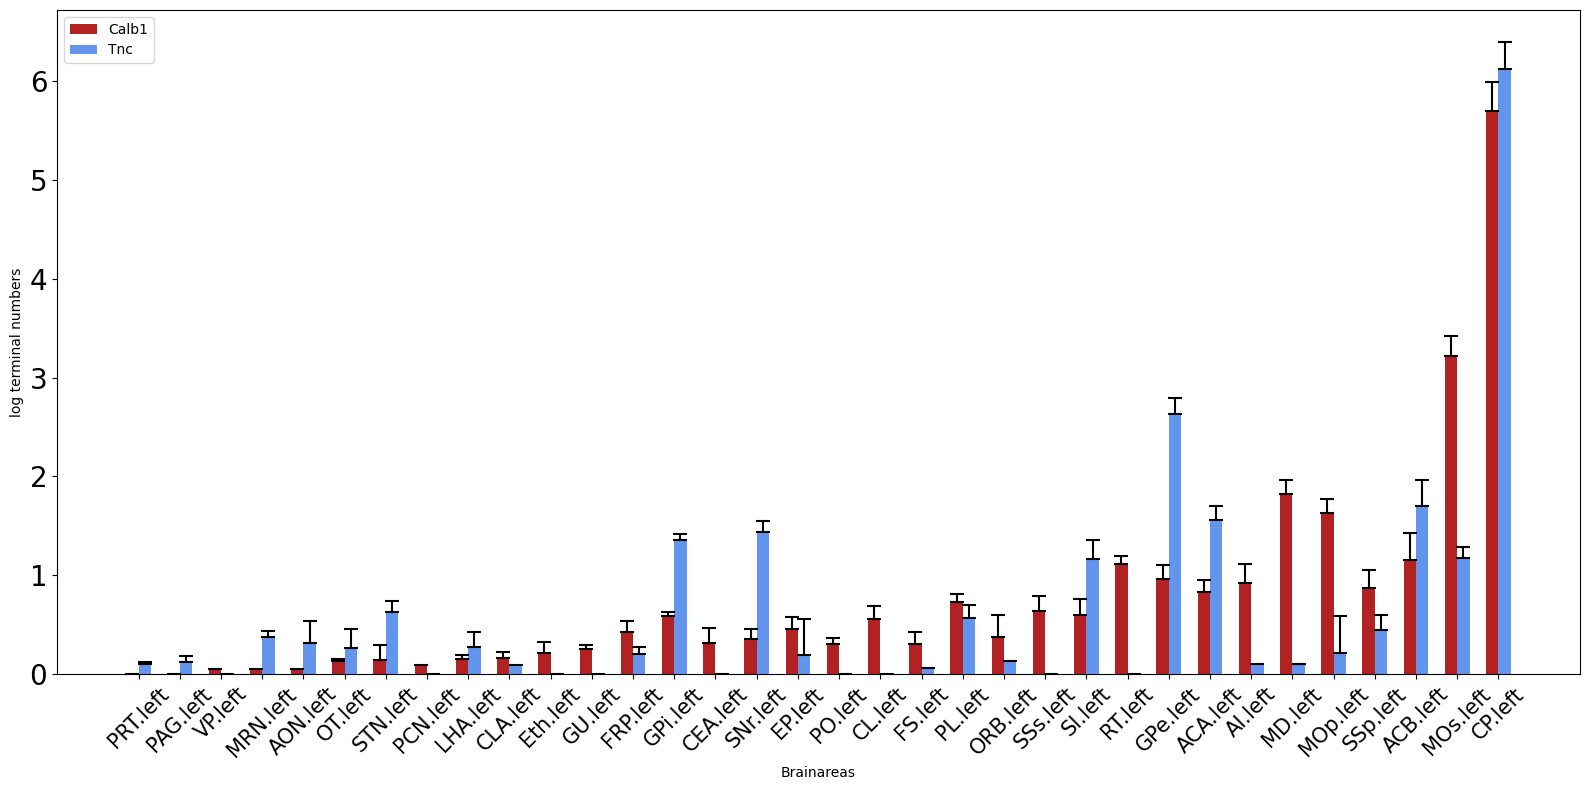

In [19]:
from scipy.stats import ttest_ind
import math
brainarea_intensity_calb1=neurondata_st8_screen[neuronlist_df[neuronlist_df['sourse']=='Calb1']['ID']] 
brainarea_intensity_Tnc=neurondata_st8_screen[neuronlist_df[neuronlist_df['sourse']=='Tnc']['ID']]
brainarea_intensity_calb1 = brainarea_intensity_calb1.drop(index=['PF.left'])
brainarea_intensity_Tnc = brainarea_intensity_Tnc.drop(index=['PF.left'])
brainarea_intensity_calb1=brainarea_intensity_calb1[~(brainarea_intensity_calb1==0).all(axis=1)] 
brainarea_intensity_Tnc=brainarea_intensity_Tnc[~(brainarea_intensity_Tnc==0).all(axis=1)] 
brainarea_intensity_calb1['Rowsum']=brainarea_intensity_calb1.sum(axis=1)
brainarea_intensity_calb1=brainarea_intensity_calb1.sort_values(by='Rowsum')
brainarea_intensity_calb1 = brainarea_intensity_calb1.drop(columns=['Rowsum']) 
calb1_index=brainarea_intensity_calb1.index
brainarea_intensity_Tnc=brainarea_intensity_Tnc.reindex(calb1_index)
# brainarea_intensity_calb1=brainarea_intensity_calb1.apply(np.log)
# brainarea_intensity_Tnc=brainarea_intensity_Tnc.apply(np.log)
# 确保两个 DataFrame 行名一致
assert (brainarea_intensity_calb1.index == brainarea_intensity_Tnc.index).all(), "行名必须一致"
# 进行独立样本 t 检验
t_results=[]
p_value=[]
for row in brainarea_intensity_calb1.index:
    values1 = brainarea_intensity_calb1.loc[row].values
    values2 = brainarea_intensity_Tnc.loc[row].values
    
    if np.all(np.isnan(values1)) and np.all(np.isnan(values2)):
      brainarea_intensity_calb1.drop([row], inplace=True)
      brainarea_intensity_Tnc.drop([row], inplace=True)
      continue
    else:
    # 进行独立样本 t 检验
      #  breakpoint()
       values1=np.nan_to_num(values1)
       values2=np.nan_to_num(values2)
       t_stat, p = ttest_ind(values1, values2)
       t_results.append(t_stat)
       p_value.append(p)
#显示每个脑区的p_value
brainarea_intensity_calb1['p_value']=p_value   
brainarea_intensity_calb1 = brainarea_intensity_calb1.drop(columns=['p_value']) 
# 为了作图均一将所有terminal取log
brainarea_intensity_calb1=brainarea_intensity_calb1.apply(np.log)
brainarea_intensity_Tnc=brainarea_intensity_Tnc.apply(np.log)

x = np.arange(2,len(brainarea_intensity_calb1.index)+2)  # 行的索引作为 x 轴位置
width = 0.3  # 柱状图宽度
# 计算每一行的均值
sums1 = brainarea_intensity_calb1.sum(axis=1)/len(brainarea_intensity_calb1.columns)
sums2 = brainarea_intensity_Tnc.sum(axis=1)/len(brainarea_intensity_Tnc.columns)
sem1=brainarea_intensity_calb1.std(axis=1)/np.sqrt(len(brainarea_intensity_calb1.columns))
sem2=brainarea_intensity_Tnc.std(axis=1)/np.sqrt(len(brainarea_intensity_Tnc.columns))

# 绘制柱状图
fig, ax = plt.subplots(figsize=(16, 8))
bar1 = ax.bar(x - width/2, sums1, width,label='Calb1', color='#B22222')
ax.errorbar(x - width/2, sums1, yerr=[np.zeros_like(sem1), sem1], fmt='none', ecolor='black', capsize=5, capthick=1.5, elinewidth=1.5)
bar2 = ax.bar(x + width/2, sums2, width,label='Tnc', color='#6495ED')
ax.errorbar(x + width/2, sums2, yerr=[np.zeros_like(sem2), sem2], fmt='none', ecolor='black', capsize=5, capthick=1.5, elinewidth=1.5)
# 手动添加 T 形误差线

# 添加 p 值到图中
# for i, (bar1_rect, bar2_rect, p_value) in enumerate(zip(bar1, bar2, p_value)):
#     if p_value<0.05:
#          height = max(bar1_rect.get_height(), bar2_rect.get_height())
#          ax.text(x[i], height + 1, f"p={p_value:.4f}", ha='center', fontsize=10)

# 设置图形属性
ax.set_xlabel("Brainareas")
ax.set_ylabel("log terminal numbers")
ax.set_xticks(x)
plt.xticks(rotation=45,fontsize=15)  # 使 x 轴标签水平显示
plt.yticks(fontsize=20)
ax.set_xticklabels(brainarea_intensity_calb1.index)
ax.legend()

# 显示图形
plt.tight_layout()
plt.savefig('D:\Figure/24\paper/figure 4/calb_Tnc_terminal.pdf')
plt.show()



In [18]:
brainarea_intensity_calb1['p_value']=p_value

In [ ]:
brainarea_intensity_calb1['p_value'] 

PRT.left    0.151350
PAG.left    0.164571
VP.left     0.327381
MRN.left    0.033396
AON.left    0.202453
OT.left     0.275620
STN.left    0.067539
PCN.left    0.327381
LHA.left    0.534044
CLA.left    0.692681
Eth.left    0.117217
GU.left     0.088201
FRP.left    0.307226
GPi.left    0.001182
CEA.left    0.124229
SNr.left    0.011432
EP.left     0.825705
PO.left     0.099925
CL.left     0.022282
FS.left     0.137254
PL.left     0.751873
ORB.left    0.671254
SSs.left    0.033865
SI.left     0.096256
RT.left     0.000106
GPe.left    0.047541
ACA.left    0.104562
AI.left     0.031731
MD.left     0.000019
MOp.left    0.071508
SSp.left    0.181929
ACB.left    0.185132
MOs.left    0.000098
CP.left     0.078736
Name: p_value, dtype: float64

In [73]:
#挑选雷达图绘制脑区
region_draw=['AI.left',
         'MOs.left',
         'SSs.left',
         'MOp.left',
         'SSp.left',
         'ACA.left',
         'ORB.left',
         'PL.left',
         'ACB.left',
         'CP.left',
         'SNr.left']
propotion_terminal_log=propotion_terminal_log.loc[region_draw]
target_area=['MOs.left','MOp.left']      
def pick_cluster(propotion_data, target_area):
    aim_cluster=propotion_data.loc[:,(propotion_data.loc[target_area[0]]!=0)&(propotion_data.loc[target_area[1]]==0)]
    return aim_cluster
mos_cp_cluster=pick_cluster(propotion_data=propotion_terminal_log, target_area=target_area)           